### Packages

In [1]:
import os
import time
import random
import argparse
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

In [2]:
np.random.seed(7)
torch.manual_seed(0)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [4]:
dataset_origin = {'100k': 'u.data', '1M': 'ratings.dat'}

num_sample_data = '100k'
#DATA_PATH = 'drive/MyDrive/Colab Notebooks/2 - Data/{}'.format(dataset_origin[num_sample_data]) #change this with your directory 
DATA_PATH = 'data/input/MovieLens/{}'.format(dataset_origin[num_sample_data]) #change this with your directory 
#MODEL_PATH = 'drive/MyDrive/Colab Notebooks/2 - Models/movielens_{}/'.format(num_sample_data) #change this with your directory 
MODEL_PATH = 'data/output/models/movielens_{}/'.format(num_sample_data) #change this with your directory 

In [5]:
class Rating_Dataset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Dataset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

In [6]:
class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)

	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample((x), self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Dataset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Dataset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

In [7]:
def hit(ng_item, pred_items):
	# fraction of users for which the correct answer is included in the recommendation list of length L
	# numeratore: number of users for which the correct answer is included in the top L recommendation list
	# denominatore: total number of user in the test dataset
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	topk_user = {}
	for user, item, label in test_loader:
		#print("----------debug, user:", user, "\n", "----------debug, item:", item)
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)          # lista di probabilità associate ad ogni item
		_, indices = torch.topk(predictions, top_k) # prende le topk probabilità 
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()		
		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		# si va a vedere se il preferito è presente nella lista degli item raccomandati
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

		topk_dict = {}
		for k in range(0, top_k):
			ng_item = item[k].item()
			HR_k = hit(ng_item, recommends)
			NDCG_k = ndcg(ng_item, recommends)
			topk_dict[k] = HR_k


		topk_user[user[0].item()] = topk_dict
	return np.mean(HR), np.mean(NDCG), topk_user

In [15]:
class GMF(nn.Module):
    def __init__(self, f, num_users, num_items): # (self, args, num_users, num_items)
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = f # args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [9]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num # numero di predictive factors
        self.layers = args.layers # lista del numero di layer

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [10]:
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed", 
	type=int, 
	default=42, 
	help="Seed")
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.2,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=256, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=30,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	# type=int,
	nargs='+',
	default=[8,16,32,64], 
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+', 
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng", 
	type=int,
	default=4, 
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", 
	type=int,
	default=100, 
	help="Number of negative samples for test set")
parser.add_argument("--out", 
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

# Recommender System - Neural Collaborative Filtering approach

In [11]:
# set device and parameters
args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# load data
ml_100k = pd.read_csv(
	DATA_PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

In [14]:
# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

/tmp/ipykernel_17215/2232885462.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_17215/2232885462.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample((x), self.num_ng))


In [17]:
hr_factor_dict = {}
ndcg_factor_dict = {}

for f in args.factor_num:
	print(f"FACTOR NUM: {f}--------------------------------------------------------------------")
	# set model and loss, optimizer
	model = GMF(f, num_users, num_items)
	model = model.to(device)
	loss_function = nn.BCELoss()
	optimizer = optim.Adam(model.parameters(), lr=args.lr)

	# train, evaluation
	best_hr = 0
	epoch_loss_dict = {}
	GMF_best_HR_dict = {}
	GMF_best_NDCG_dict = {}
	for epoch in range(1, args.epochs+1):
		model.train() # Enable dropout (if have).
		start_time = time.time()
		
		train_iter_loss = []
		for user, item, label in train_loader:
			user = user.to(device)
			item = item.to(device)
			label = label.to(device)

			optimizer.zero_grad()
			prediction = model(user, item)
			loss = loss_function(prediction, label)
			
			train_iter_loss.append(loss.item())
			
			loss.backward()
			optimizer.step()
			#writer.add_scalar('loss/Train_loss', loss.item(), epoch)
		
		epoch_loss_dict[epoch] = sum(train_iter_loss)/len(train_iter_loss)

		model.eval()
		HR, NDCG, topk_user = metrics(model, test_loader, args.top_k, device)

		#epoch_metrics_dict[epoch] = topk_user
		
		#writer.add_scalar('Perfomance/HR@10', HR, epoch)
		#writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

		elapsed_time = time.time() - start_time
		print("Epoch {:03d}".format(epoch) + " time to train: " + 
				time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
		print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

		if HR > best_hr:
			
			GMF_best_HR_dict[HR] = topk_user
			GMF_best_NDCG_dict[NDCG] = topk_user
			
			best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
			
			if args.out:
				if not os.path.exists(MODEL_PATH):
					os.mkdir(MODEL_PATH)
				torch.save(model, 
					'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))
				
	hr_factor_dict[f] = max(GMF_best_HR_dict.keys())
	ndcg_factor_dict[f] = max(GMF_best_NDCG_dict.keys())

FACTOR NUM: 8--------------------------------------------------------------------
Epoch 001 time to train: 00: 00: 10
HR: 0.090	NDCG: 0.041
Epoch 002 time to train: 00: 00: 13
HR: 0.090	NDCG: 0.037
Epoch 003 time to train: 00: 00: 11
HR: 0.108	NDCG: 0.050
Epoch 004 time to train: 00: 00: 11
HR: 0.147	NDCG: 0.069
Epoch 005 time to train: 00: 00: 12
HR: 0.220	NDCG: 0.104
Epoch 006 time to train: 00: 00: 10
HR: 0.286	NDCG: 0.146
Epoch 007 time to train: 00: 00: 09
HR: 0.338	NDCG: 0.181
Epoch 008 time to train: 00: 00: 09
HR: 0.365	NDCG: 0.196
Epoch 009 time to train: 00: 00: 09
HR: 0.379	NDCG: 0.202
Epoch 010 time to train: 00: 00: 09
HR: 0.392	NDCG: 0.209
Epoch 011 time to train: 00: 00: 10
HR: 0.397	NDCG: 0.210
Epoch 012 time to train: 00: 00: 10
HR: 0.394	NDCG: 0.213
Epoch 013 time to train: 00: 00: 09
HR: 0.399	NDCG: 0.216
Epoch 014 time to train: 00: 00: 10
HR: 0.394	NDCG: 0.217
Epoch 015 time to train: 00: 00: 09
HR: 0.413	NDCG: 0.224
Epoch 016 time to train: 00: 00: 09
HR: 0.425	ND

In [21]:

df_hr_factor = pd.DataFrame.from_dict(hr_factor_dict, orient='index').reset_index().rename(columns={"index":"factors", 0: "hr@10"})
df_ndcg_factor = pd.DataFrame.from_dict(ndcg_factor_dict, orient='index').reset_index().rename(columns={"index":"factors", 0: "ndcg@10"})


In [23]:
df_ndcg_factor

,factors,ndcg@10
0,8,0.324357
1,16,0.305595
2,32,0.305588
3,64,0.265567


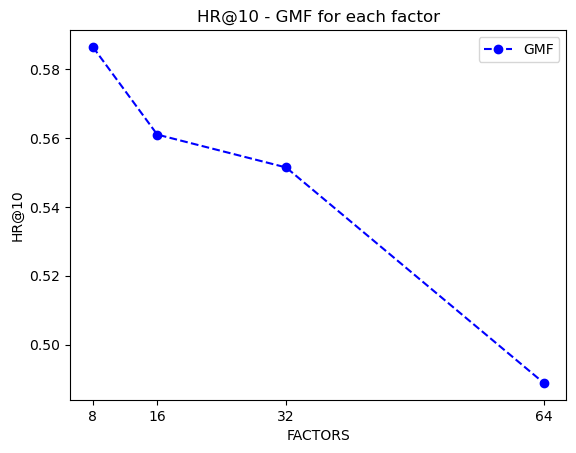

In [49]:
plt.plot(df_hr_factor['factors'], df_hr_factor['hr@10'], "--bo", label="GMF")
plt.title('HR@10 - GMF for each factor')
plt.xlabel('FACTORS')
plt.ylabel('HR@10')
plt.xticks([8,16,32,64])
#plt.yticks(np.arange(0.5,0.6))
plt.legend(loc='best')
plt.show()

In [ ]:
from numpy import arange

In [ ]:
df = pd.DataFrame.from_dict(epoch_loss_dict, orient='index').reset_index().rename(columns={"index":"epochs", 0: "training loss"})
plt.plot(df['epochs'], df['training loss'])
plt.title('Training Loss x iteration')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.xticks(arange(0, 32, 2))
plt.legend(loc='best')
plt.show()

In [ ]:
best_hr_list = []
for k in epoch_metrics_dict.keys():
    best_hr_list.append(k.astype(float))

In [ ]:
epoch_metrics_dict[max(best_hr_list)].keys()

In [ ]:
df_list = []
hr_dict = epoch_metrics_dict[max(best_hr_list)]
for k_e, v_e in hr_dict.items():
    user_dict = hr_dict[k_e]
    df_k_hr = pd.DataFrame.from_dict(user_dict, orient='index', columns=['HR'])
    df_k_hr.index.name = "k"
    df_k_hr.reset_index(inplace=True)
    df_list.append(df_k_hr)
    #for k_u, v_u in user_dict.items():
    #    print(k_u,v_u)

In [ ]:
df = pd.concat(df_list).groupby("k")['HR'].mean().reset_index()
df

In [ ]:
plt.plot(df['k'], df['HR'])
plt.title('HR@K')
plt.xlabel('k')
plt.ylabel('HR@K')
plt.xticks(arange(0, 10, 1))
plt.legend(loc='best')
plt.show()

### we employed three hidden layers for MLP; for example, if the size of predictive factors is 8, then the architecture of the NCF layers is 32 -> 16 -> 8, and the embedding size is 16.

In [ ]:
# set model and loss, optimizer
model_MLP = MLP(args, num_users, num_items)
model_MLP = model_MLP.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# train, evaluation
best_hr = 0
MLP_epoch_loss_dict = {}
MLP_epoch_metrics_dict = {}
for epoch in range(1, args.epochs+1):
	model_MLP.train() # Enable dropout (if have).
	start_time = time.time()

	MLP_train_iter_loss = []
	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model_MLP(user, item)
		loss = loss_function(prediction, label)

		MLP_train_iter_loss.append(loss.item())

		loss.backward()
		optimizer.step()
		#writer.add_scalar('loss/Train_loss', loss.item(), epoch)
	
	epoch_loss_dict[epoch] = sum(MLP_train_iter_loss)/len(MLP_train_iter_loss)
	
	model_MLP.eval()
	HR_MLP, NDCG_MLP, topk_user = metrics(model_MLP, test_loader, args.top_k, device)

	#writer.add_scalar('Perfomance/HR@10', HR, epoch)
	#writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " + 
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR_MLP), np.mean(NDCG_MLP)))

	if HR_MLP > best_hr:
		MLP_epoch_metrics_dict[HR] = topk_user
		best_hr, best_ndcg, best_epoch = HR_MLP, NDCG_MLP, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model, 
				'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))


In [ ]:
df = pd.DataFrame.from_dict(epoch_loss_dict, orient='index').reset_index().rename(columns={"index":"epochs", 0: "training loss"})
df.head(2)

In [ ]:
from numpy import arange

In [ ]:
plt.plot(df['epochs'], df['training loss'])
plt.title('Training Loss x iteration')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.xticks(arange(0, 32, 2))
plt.legend(loc='best')
plt.show()

TASK 1: implement the model as described (NeuMF)

TASK 2: compare the performance of such model with the GMF and MLP models using the metrics provided. 

TASK 3: tune the networks by plotting HR@10 and NDCG@10 with respect to the number of predictive factors [8, 16, 32, 64] for all the 3 algorithms


In [ ]:
class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()
        #self.config = config
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim_mf = args.latent_dim_mf
        self.latent_dim_mlp = args.latent_dim_mlp

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(args.layers[:-1], args.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=args.layers[-1] + self.latent_dim_mf, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

In [ ]:
# set model and loss, optimizer
model_NeuMF = NeuMF(args, num_users, num_items)
model_MLP = model_MLP.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# train, evaluation
best_hr = 0
MLP_epoch_loss_dict = {}
MLP_epoch_metrics_dict = {}
for epoch in range(1, args.epochs+1):
	model_MLP.train() # Enable dropout (if have).
	start_time = time.time()

	MLP_train_iter_loss = []
	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model_MLP(user, item)
		loss = loss_function(prediction, label)

		MLP_train_iter_loss.append(loss.item())

		loss.backward()
		optimizer.step()
		#writer.add_scalar('loss/Train_loss', loss.item(), epoch)
	
	epoch_loss_dict[epoch] = sum(MLP_train_iter_loss)/len(MLP_train_iter_loss)
	
	model_MLP.eval()
	HR_MLP, NDCG_MLP, topk_user = metrics(model_MLP, test_loader, args.top_k, device)

	#writer.add_scalar('Perfomance/HR@10', HR, epoch)
	#writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " + 
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR_MLP), np.mean(NDCG_MLP)))

	if HR_MLP > best_hr:
		MLP_epoch_metrics_dict[HR] = topk_user
		best_hr, best_ndcg, best_epoch = HR_MLP, NDCG_MLP, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model, 
				'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))
